--- 1. Generating Simulated Hourly Data for March 2024 ---
Simulated data head:
                     HourOfDay  DayOfWeek  DayOfMonth        LMP  \
2024-03-01 00:00:00          0          4           1  32.517953   
2024-03-01 01:00:00          1          4           1  34.719685   
2024-03-01 02:00:00          2          4           1  38.889994   
2024-03-01 03:00:00          3          4           1  39.457064   
2024-03-01 04:00:00          4          4           1  39.055989   

                          Load_MW  Temperature_F   Wind_Gen_MW  Solar_Gen_MW  \
2024-03-01 00:00:00  41501.540031      62.551236  16813.885618           0.0   
2024-03-01 01:00:00  44980.702312      66.964214  15094.373890           0.0   
2024-03-01 02:00:00  49764.419356      59.191567  15516.156020           0.0   
2024-03-01 03:00:00  56104.905483      61.405048  14733.775076           0.0   
2024-03-01 04:00:00  56384.675621      54.900906  13206.921481           0.0   

                     NatGasPri

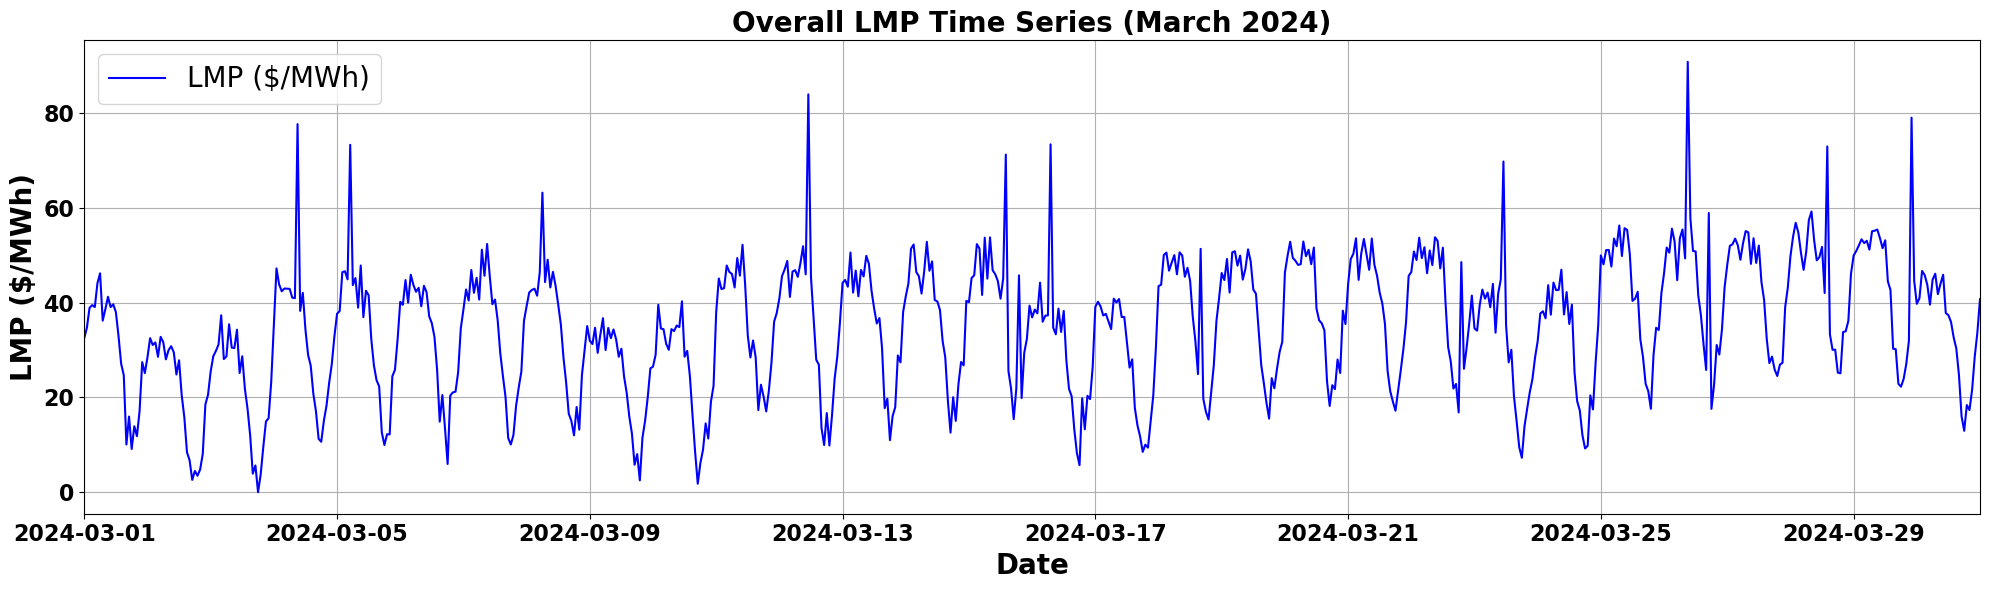

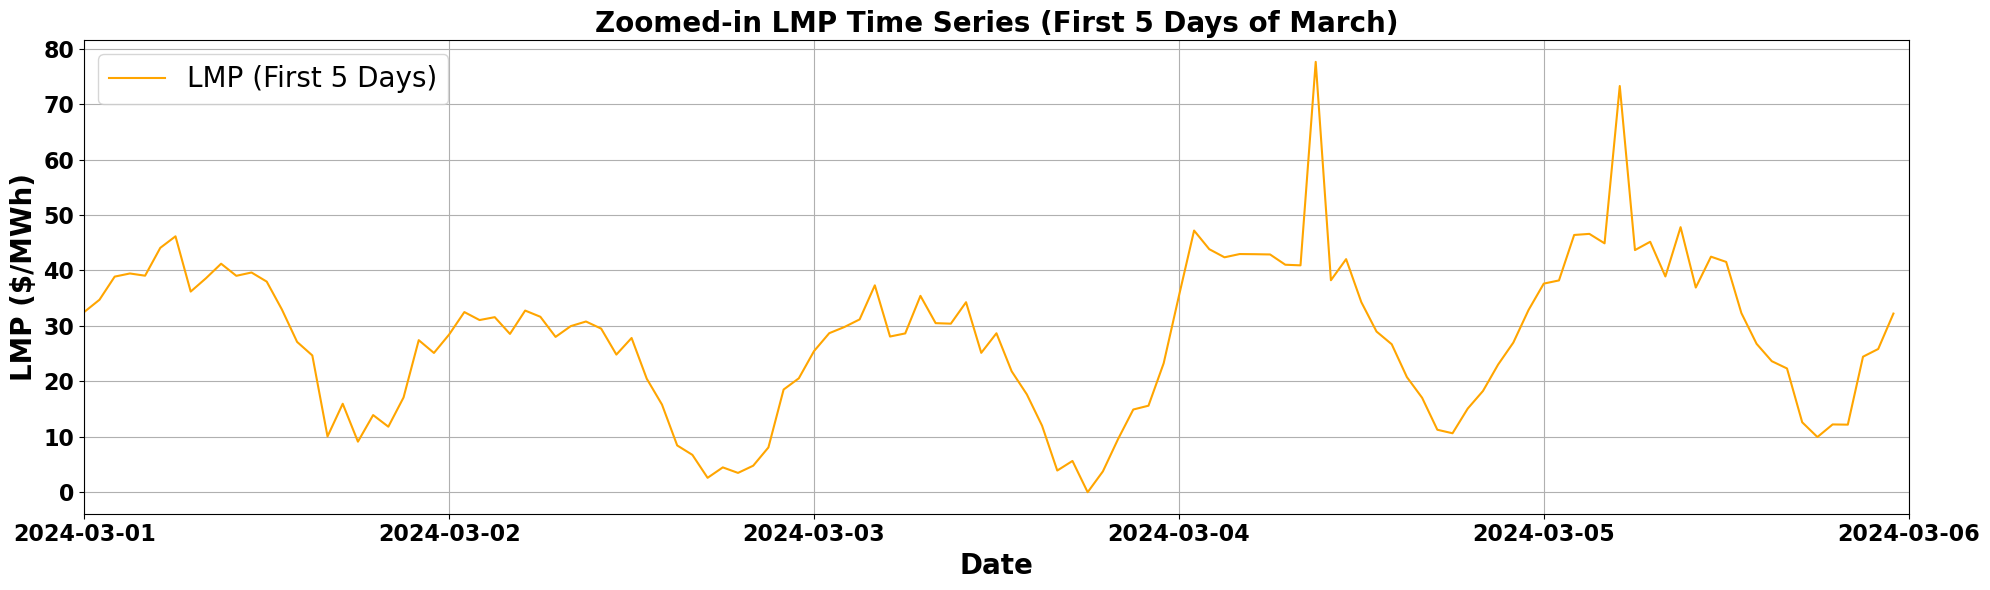

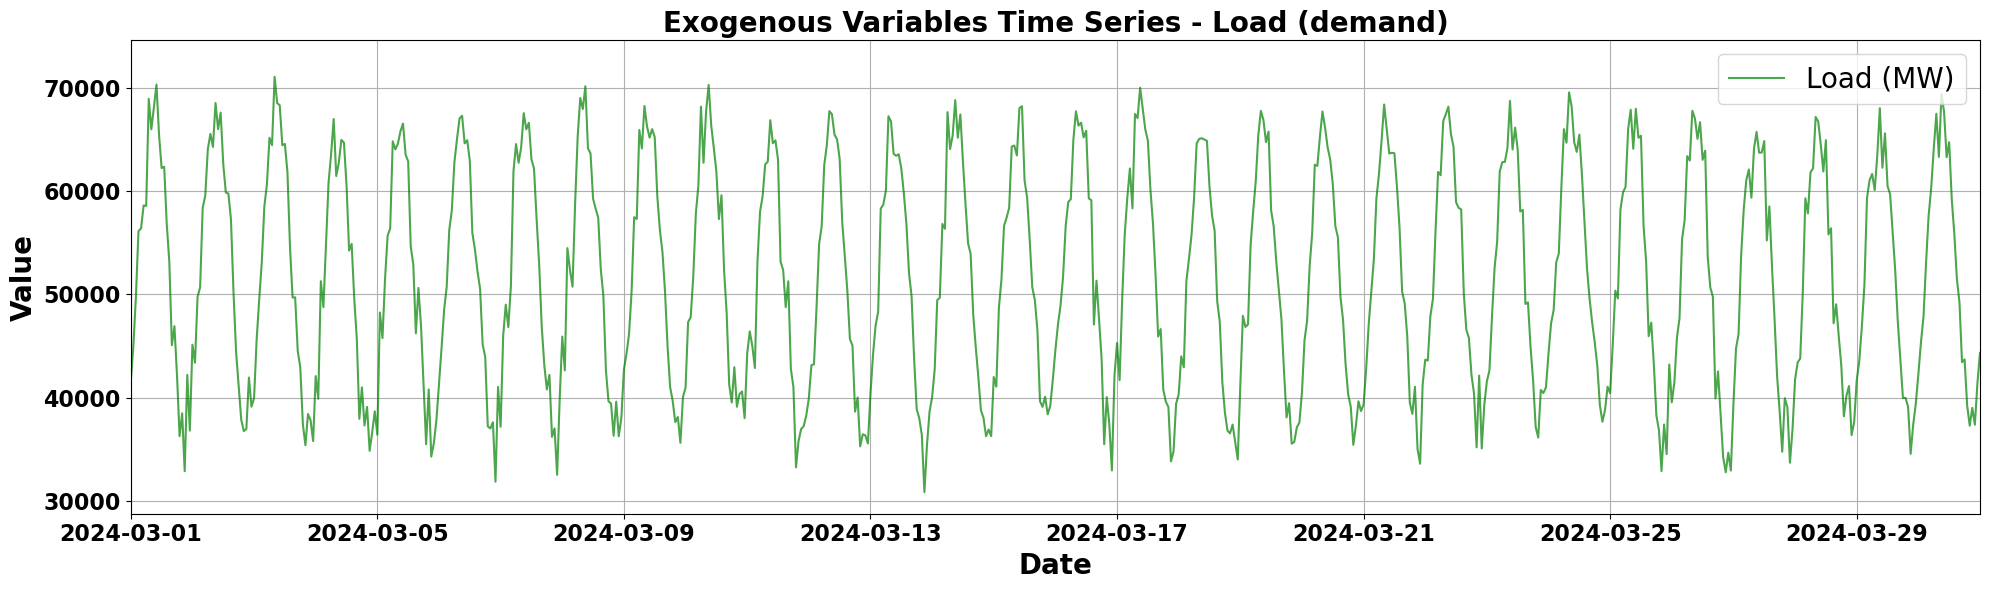

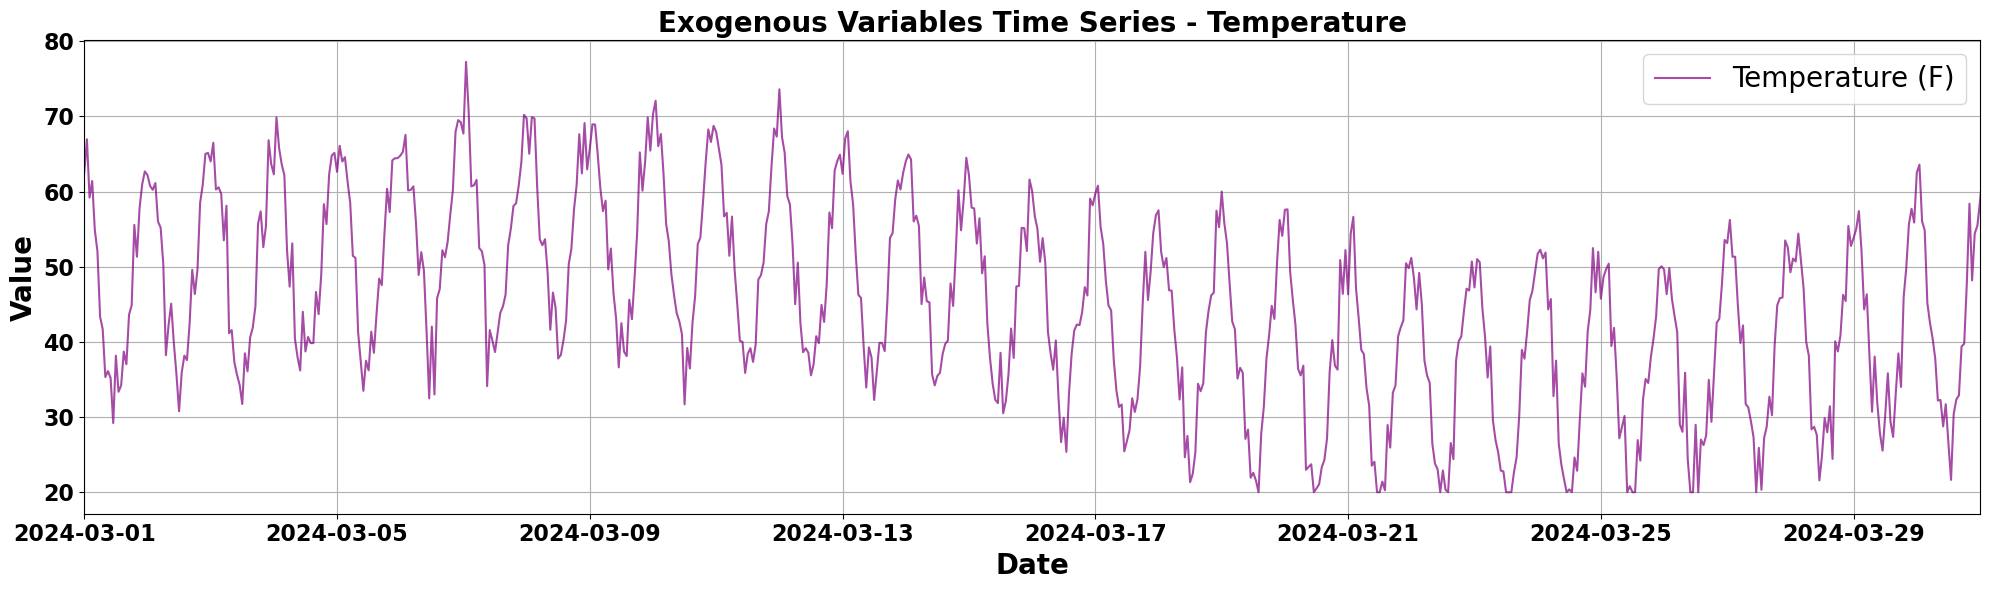

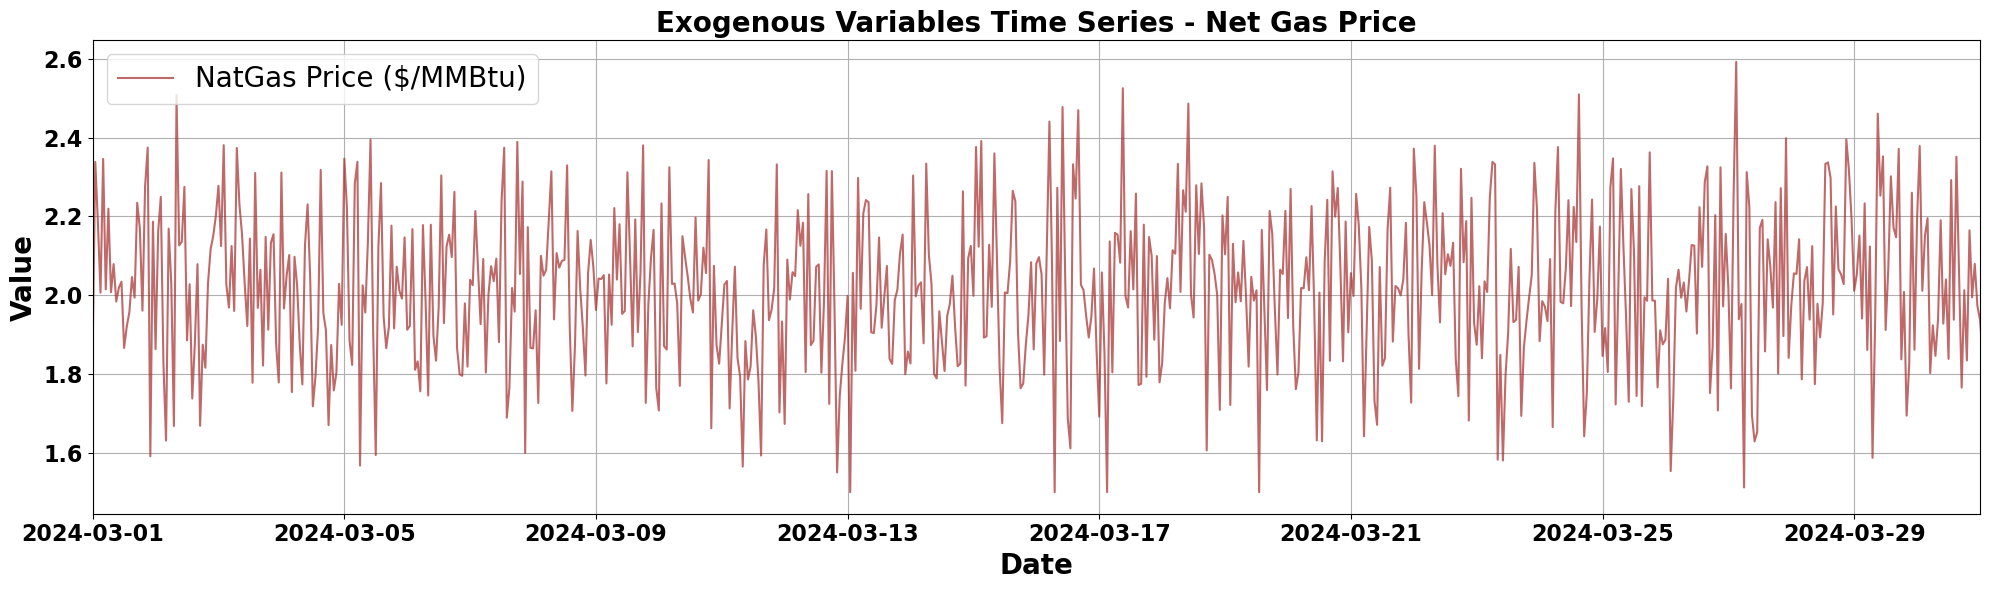

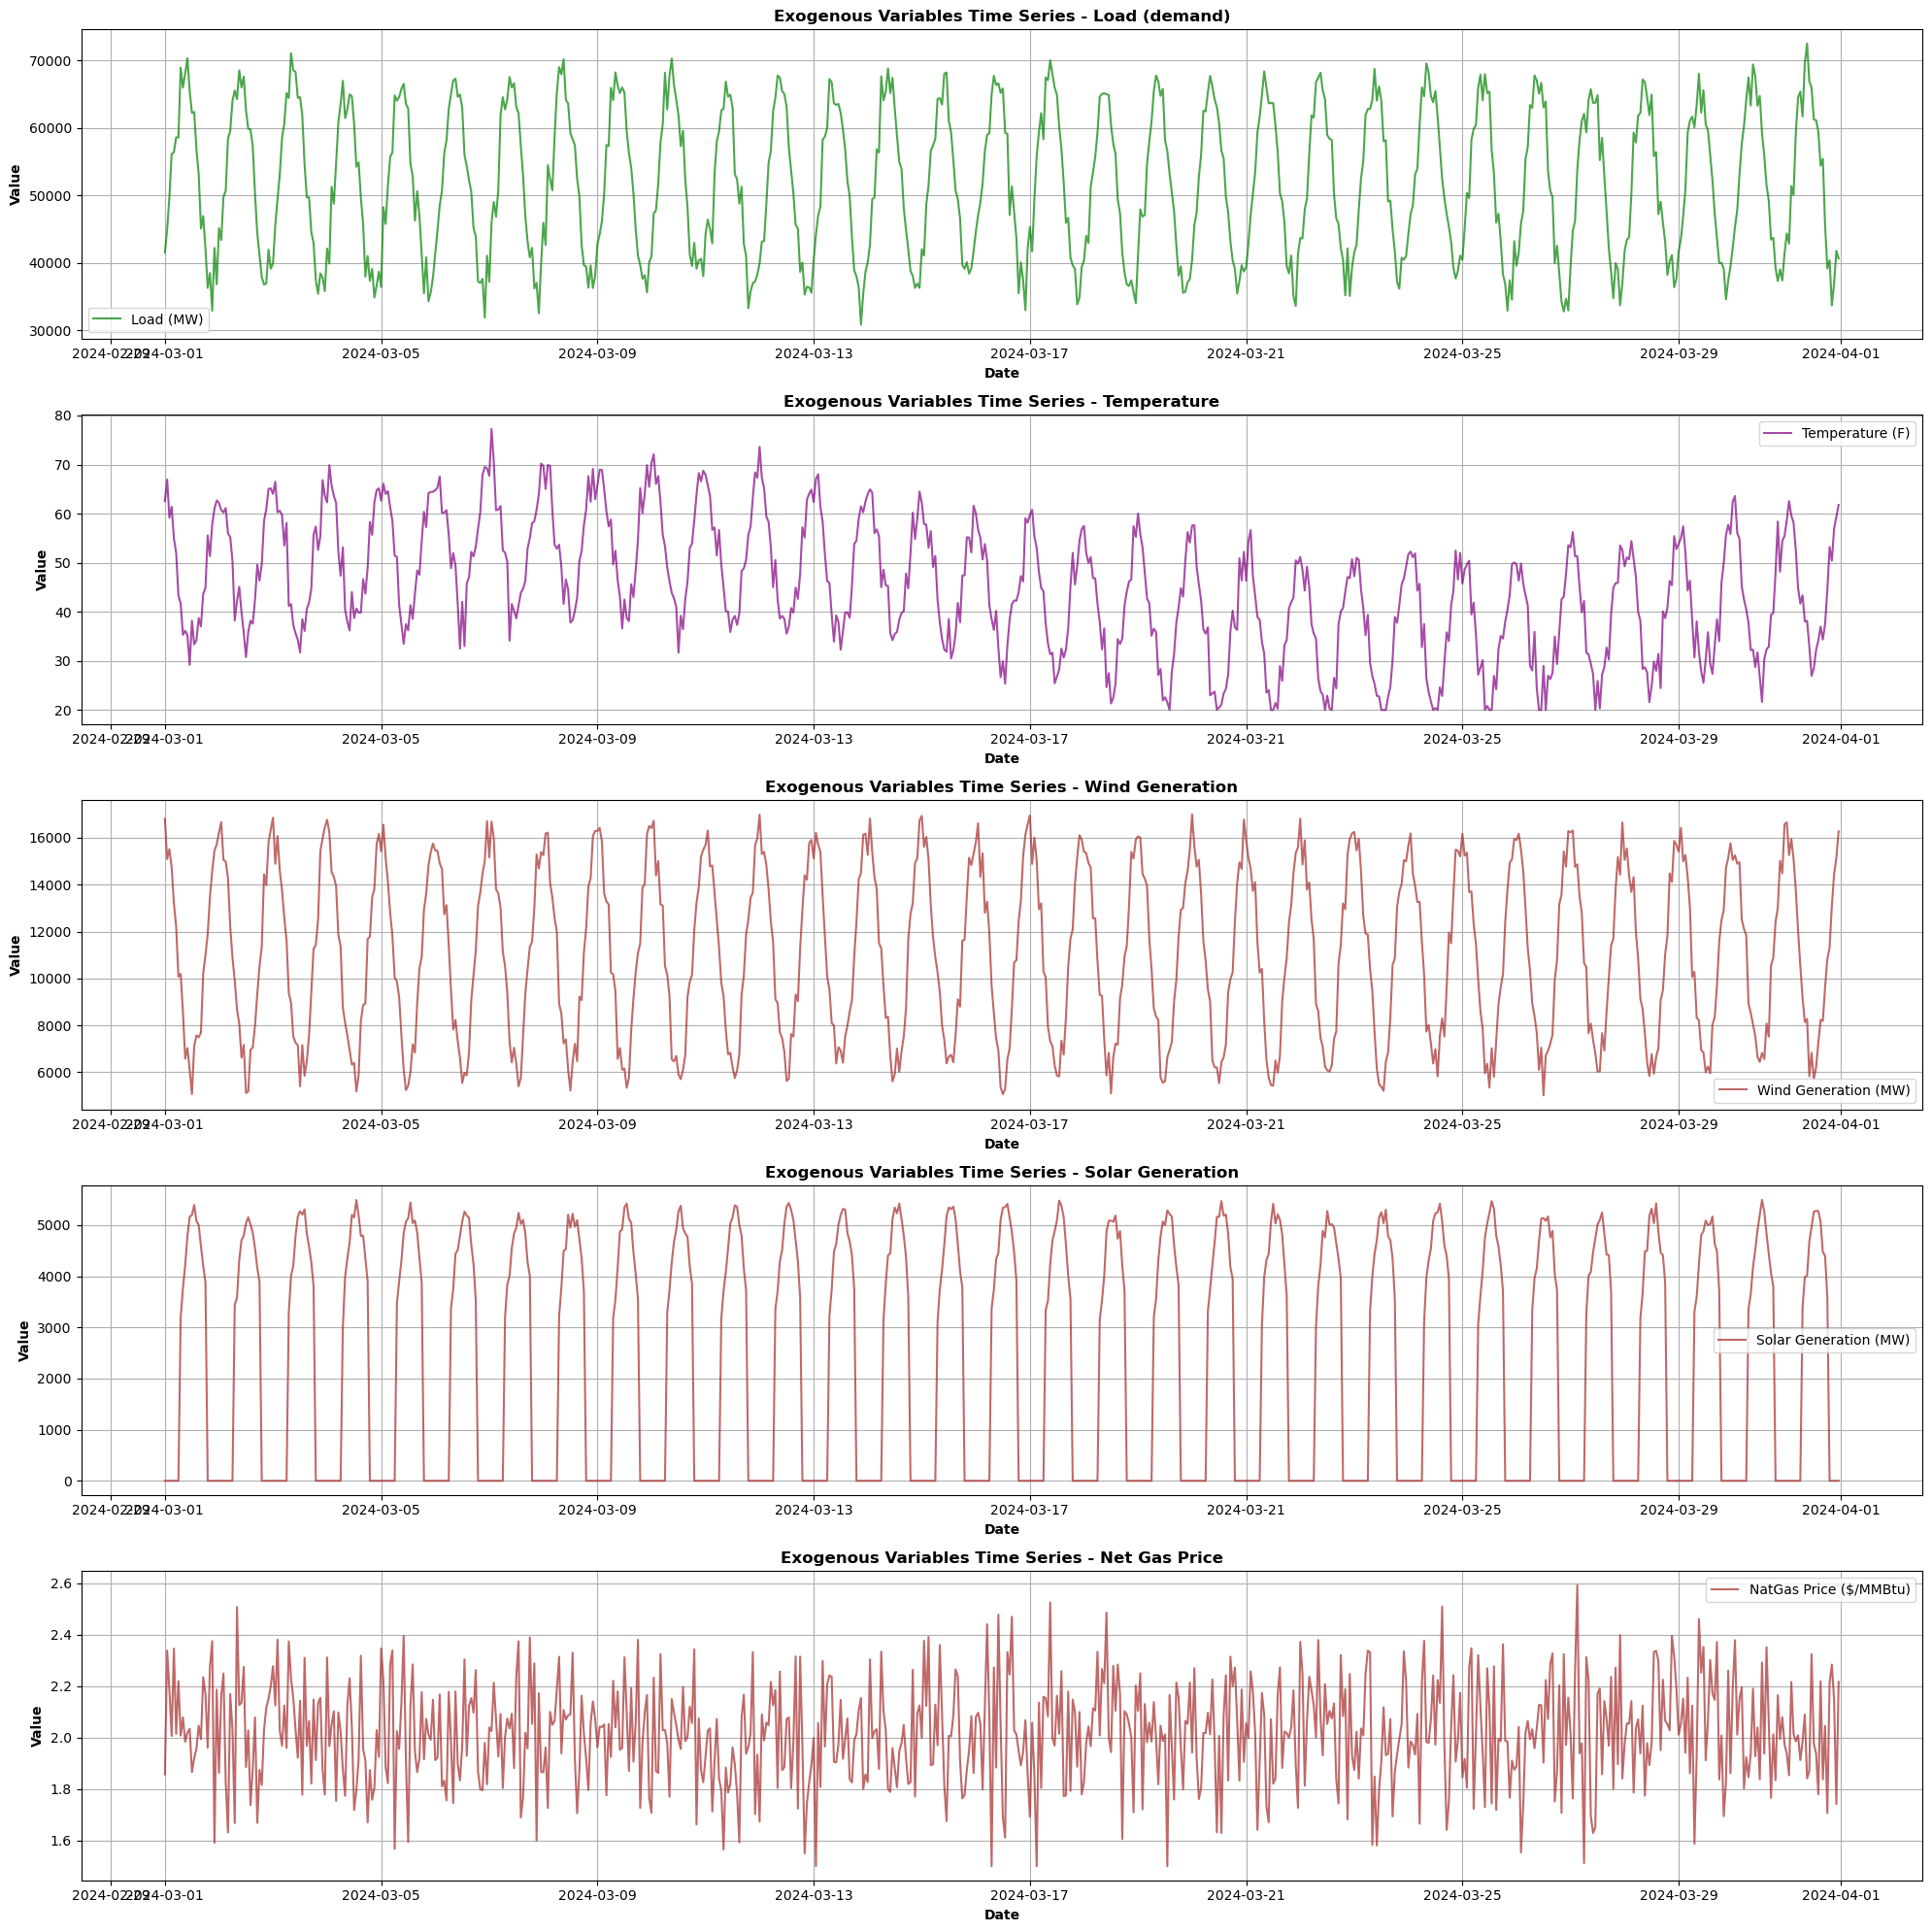


--- Seasonal Decomposition of LMP (Daily Seasonality) ---


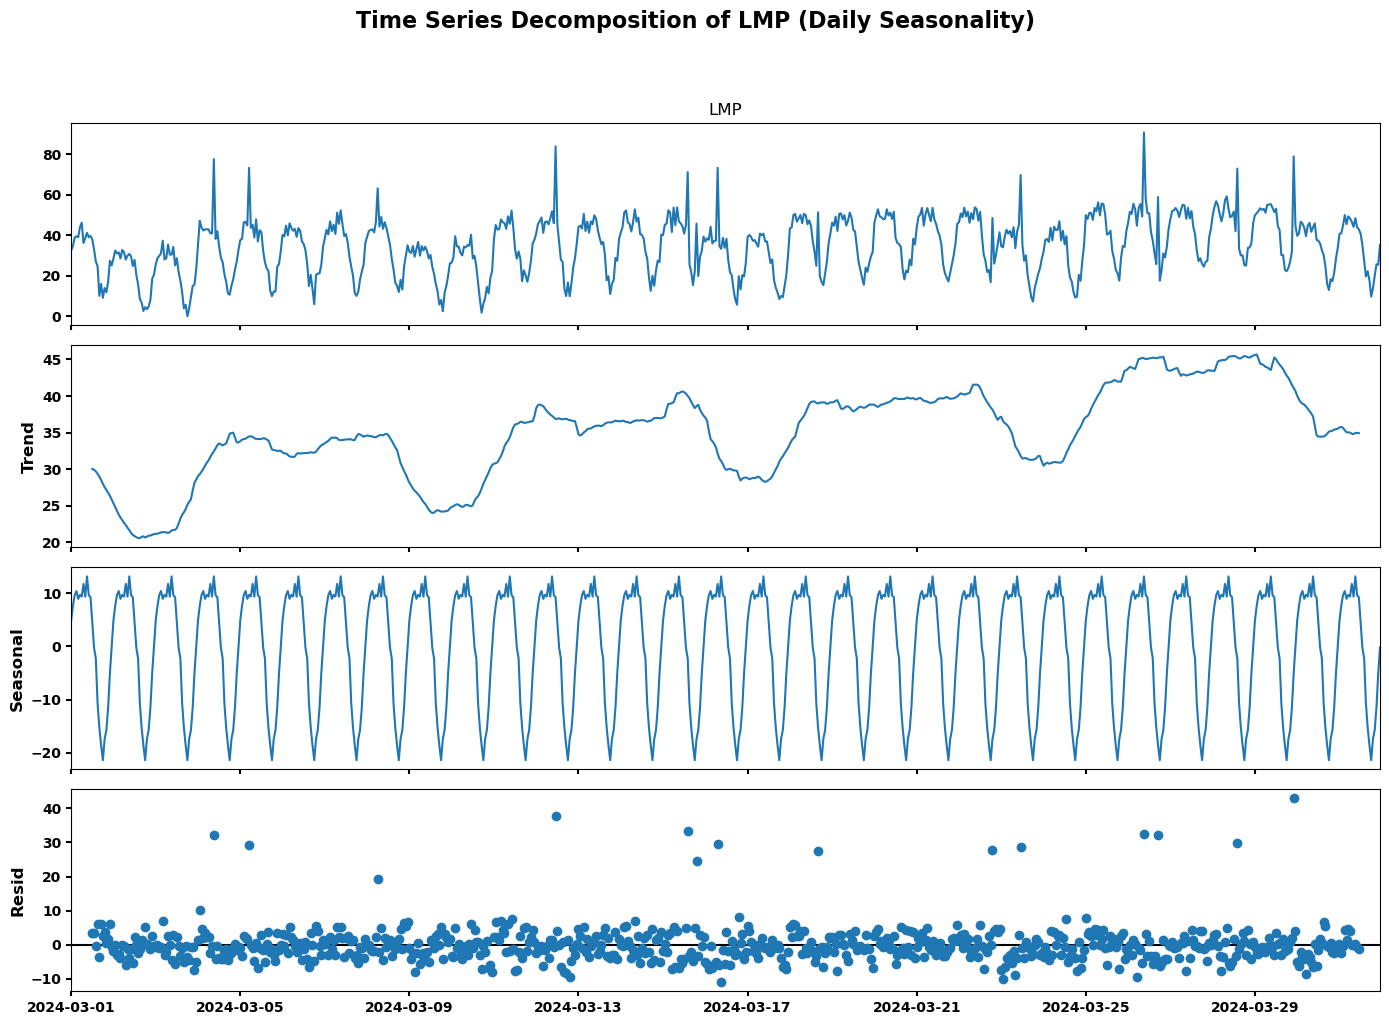

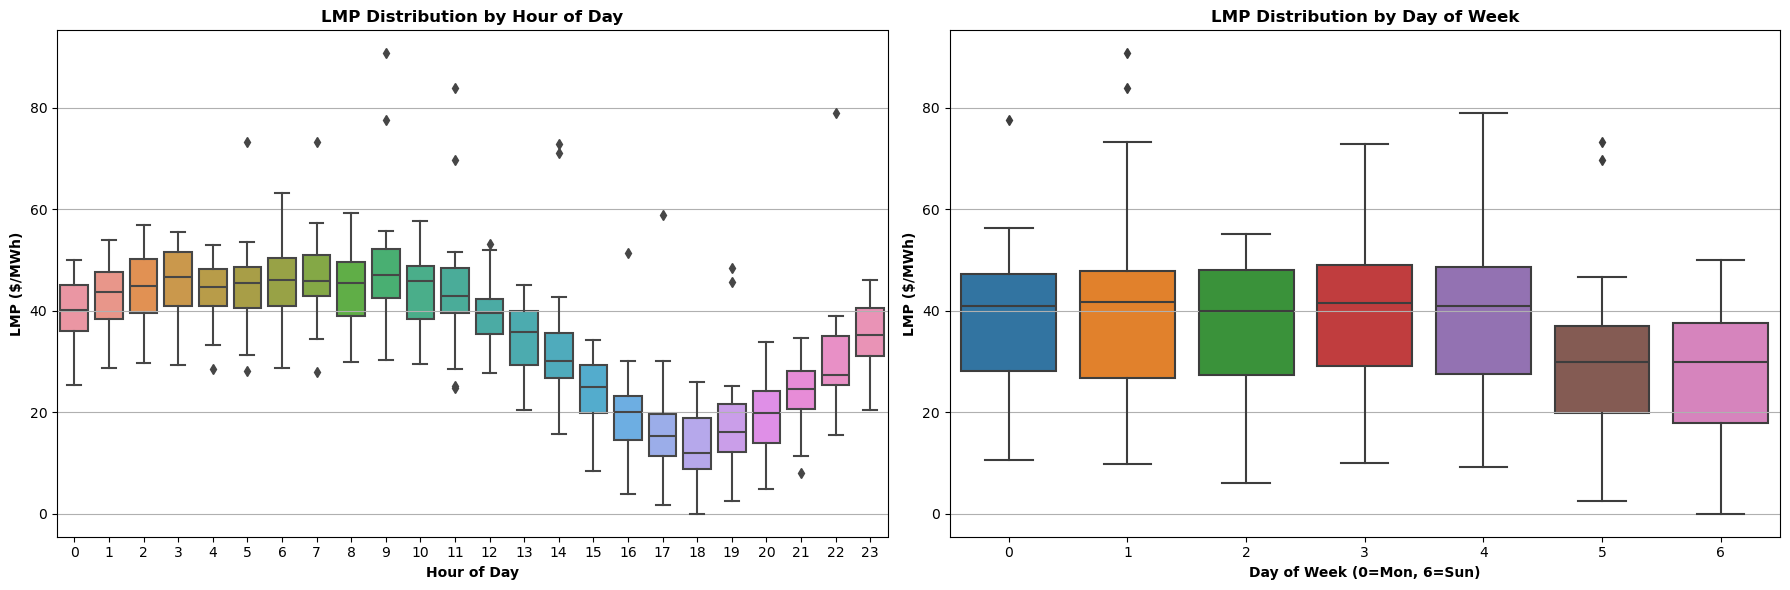

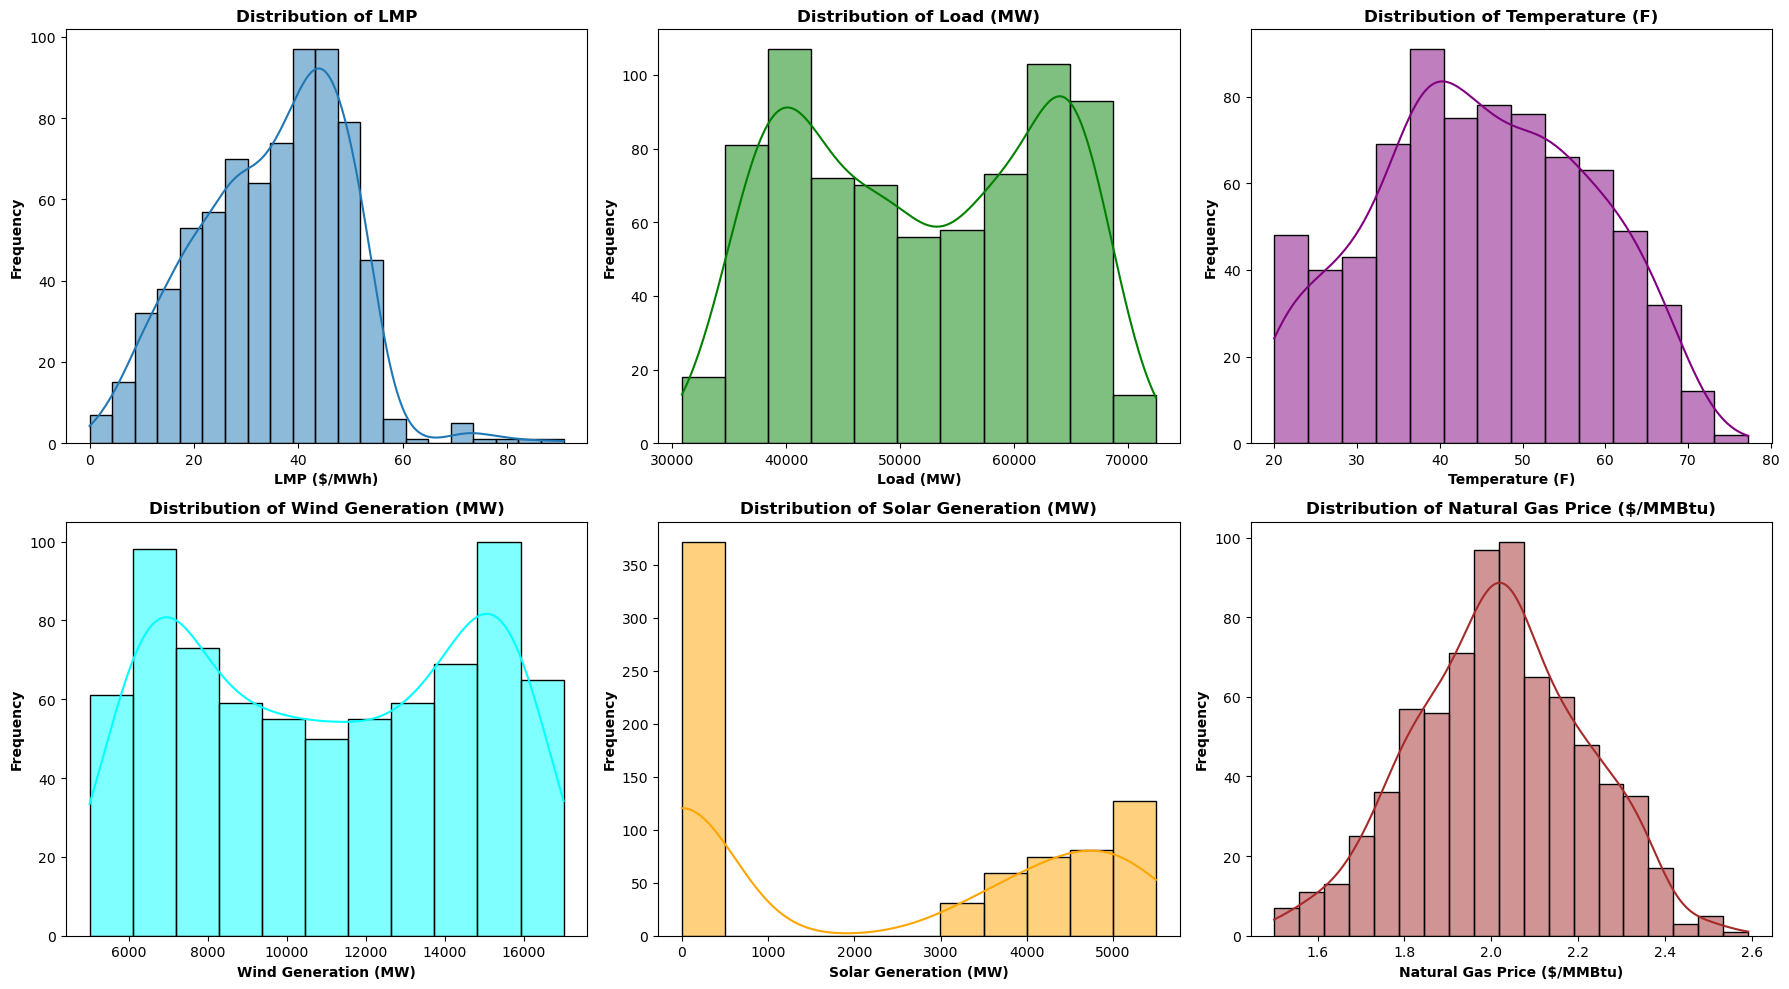


--- Autocorrelation and Partial Autocorrelation Functions (ACF/PACF) for LMP ---


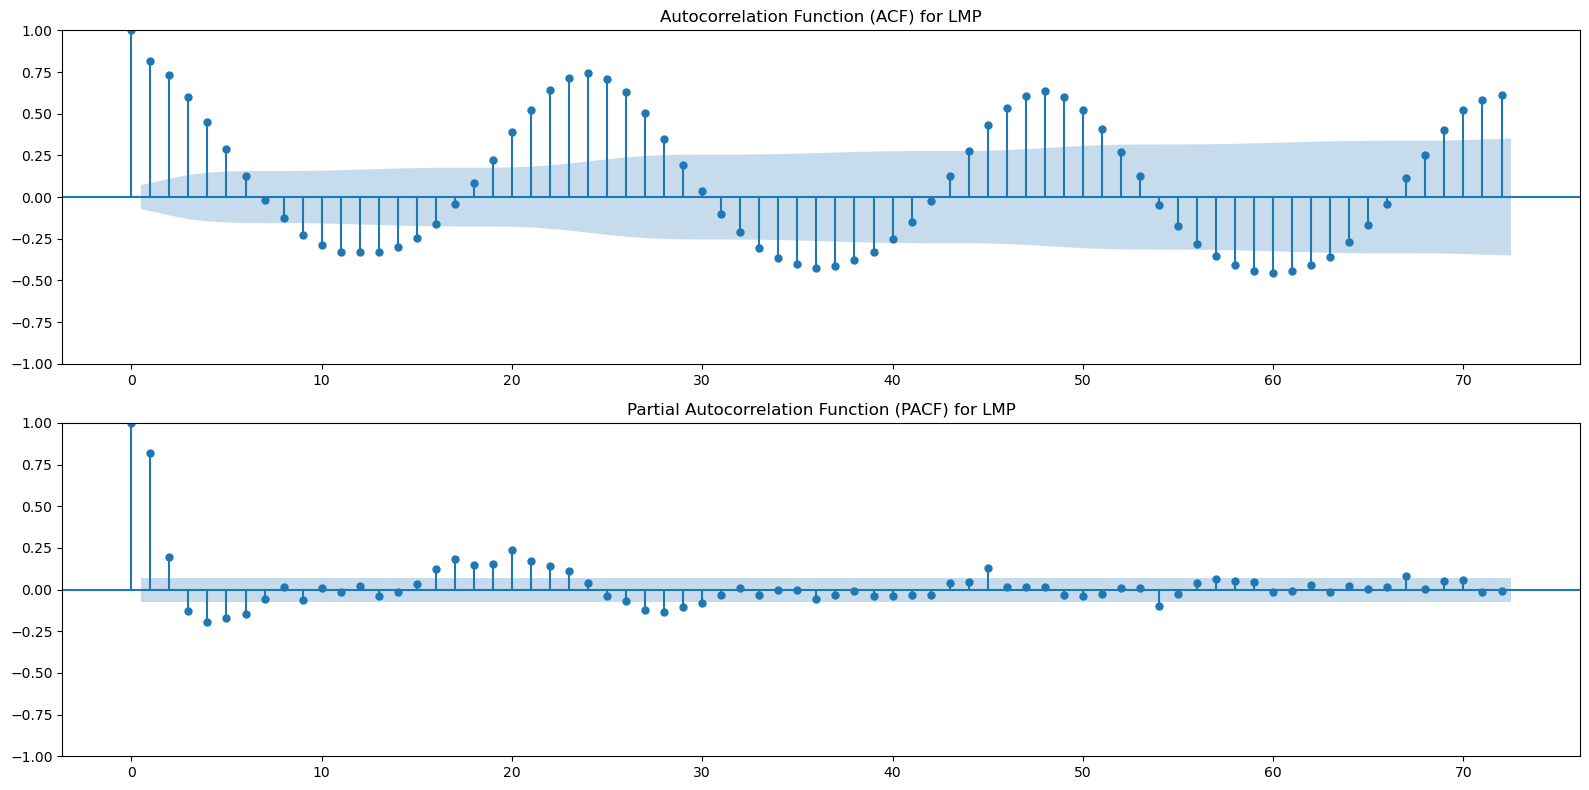


--- Correlation Heatmap ---


<Figure size 1200x1000 with 0 Axes>

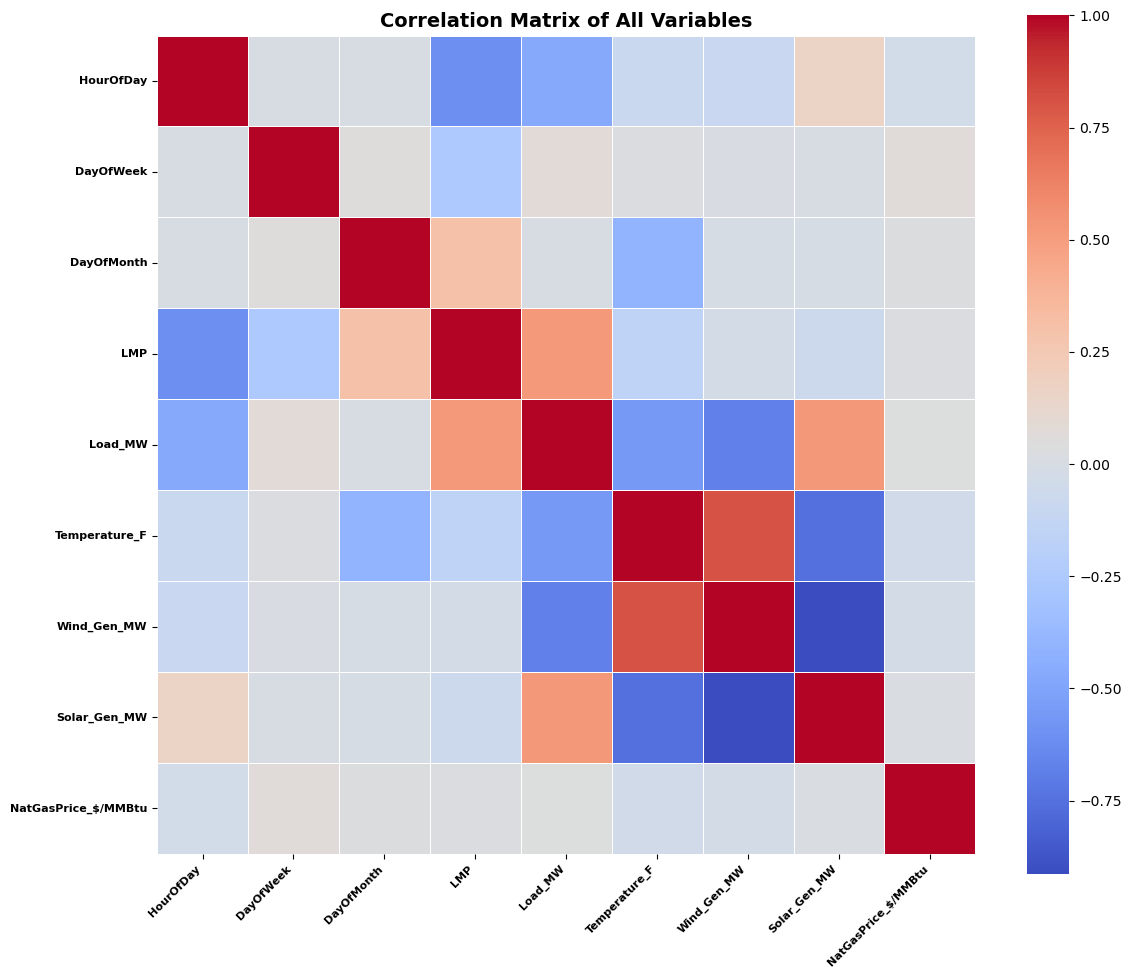


EDA complete.

--- 3. Feature Engineering (for Exogenous Variables) ---

--- 4. SARIMAX Model Training ---
Training data from 2024-03-01 00:00:00 to 2024-03-25 23:00:00 (Shape: (600, 9))
Test data from 2024-03-26 00:00:00 to 2024-03-31 23:00:00 (Shape: (144, 9))
SARIMAX Orders: Non-seasonal=(2, 1, 1), Seasonal=(1, 1, 1, 24)


In [20]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output in a demonstration
import warnings
warnings.filterwarnings("ignore")

# --- 1. Generate Simulated Hourly Data for March 2024 ---
print("--- 1. Generating Simulated Hourly Data for March 2024 ---")

start_of_month = datetime(2024, 3, 1, 0, 0)
end_of_month = datetime(2024, 3, 31, 23, 0) # End of March 2024
num_hours = (end_of_month - start_of_month).days * 24 + (end_of_month - start_of_month).seconds // 3600 + 1
dates = pd.date_range(start=start_of_month, periods=num_hours, freq='H')

price_data = pd.DataFrame(index=dates)
price_data['HourOfDay'] = price_data.index.hour
price_data['DayOfWeek'] = price_data.index.dayofweek # Monday=0, Sunday=6
price_data['DayOfMonth'] = price_data.index.day

# Base LMP with an upward trend and some noise
base_lmp = np.linspace(30, 45, num_hours) + np.random.normal(0, 3, num_hours)

# Daily seasonality (peaks in morning/evening, lows overnight)
daily_seasonality = 15 * np.sin(price_data['HourOfDay'] * 2 * np.pi / 24) + \
                    5 * np.cos(price_data['HourOfDay'] * 4 * np.pi / 24)

# Weekly seasonality (e.g., lower on weekends)
weekly_seasonality = -10 * (price_data['DayOfWeek'] >= 5) # -10 for Sat/Sun

# Price spikes (simulating market events/congestion)
spikes = np.zeros(num_hours)
# Random spikes
np.random.seed(42) # for reproducibility
spike_hours = np.random.choice(num_hours, size=int(num_hours * 0.02), replace=False)
spikes[spike_hours] = np.random.uniform(20, 40, size=len(spike_hours)) # Moderate spikes

# Combine to form LMP
price_data['LMP'] = base_lmp + daily_seasonality + weekly_seasonality + spikes
price_data['LMP'] = np.maximum(0.01, price_data['LMP']) # Ensure positive prices

# --- Simulated Exogenous Variables ---
# These are crucial for SARIMAX and would come from actual forecasts in a real scenario.
price_data['Load_MW'] = 50000 + 15000 * np.sin(price_data['HourOfDay'] * 2 * np.pi / 24 - np.pi/4) + \
                        500 * price_data['DayOfWeek'] + np.random.normal(0, 2000, num_hours)
price_data['Load_MW'] = np.maximum(30000, price_data['Load_MW'])

price_data['Temperature_F'] = 45 + 15 * np.sin(price_data['HourOfDay'] * 2 * np.pi / 24 + np.pi/2) + \
                              10 * np.sin(price_data['DayOfMonth'] * 2 * np.pi / 31) + \
                              np.random.normal(0, 3, num_hours) # Simulating increasing temps through March
price_data['Temperature_F'] = np.maximum(20, price_data['Temperature_F'])

price_data['Wind_Gen_MW'] = 10000 + 5000 * np.cos(price_data['HourOfDay'] * 2 * np.pi / 24) + \
                            2000 * np.random.rand(num_hours)
price_data['Wind_Gen_MW'] = np.maximum(0, price_data['Wind_Gen_MW']) # Cannot be negative

price_data['Solar_Gen_MW'] = np.zeros(num_hours)
daytime_hours = (price_data['HourOfDay'] >= 7) & (price_data['HourOfDay'] <= 18)
price_data.loc[daytime_hours, 'Solar_Gen_MW'] = \
    3000 + 2000 * np.sin((price_data['HourOfDay'][daytime_hours] - 7) * np.pi / 12) + \
    500 * np.random.rand(np.sum(daytime_hours))
price_data['Solar_Gen_MW'] = np.maximum(0, price_data['Solar_Gen_MW'])

price_data['NatGasPrice_$/MMBtu'] = 2.0 + 0.2 * np.random.randn(num_hours) + \
                                   0.05 * (price_data.index - price_data.index.min()).days / 31 # Slight upward trend
price_data['NatGasPrice_$/MMBtu'] = np.maximum(1.5, price_data['NatGasPrice_$/MMBtu'])

print("Simulated data head:")
print(price_data.head())
print("\nData description:")
print(price_data.describe())

price_data.to_csv("LMP_data.csv", index=False)

# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- 2. Performing Exploratory Data Analysis (EDA) ---")

# 2.1. Basic Information and Missing Values
print("\n--- Basic Info ---")
price_data.info()
print("\n--- Missing Values ---")
print(price_data.isnull().sum())

# 2.2. Time Series Plots
plt.figure(figsize=(20, 6))
# Overall LMP Time Series Plot
plt.plot(price_data.index, price_data['LMP'], label='LMP ($/MWh)', color='blue')
plt.title('Overall LMP Time Series (March 2024)',fontsize = 20, fontweight='bold')
plt.xlabel('Date',fontsize = 20,fontweight='bold')
plt.ylabel('LMP ($/MWh)',fontsize = 20,fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlim(pd.to_datetime("2024-03-01"), pd.to_datetime("2024-03-31"))
plt.grid(True)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig('LMP.png', dpi=300, bbox_inches='tight')
plt.show()

# Zoomed-in LMP Time Series Plot (e.g., first 5 days)
plt.figure(figsize=(20, 6))
plt.plot(price_data.index[:24*5], price_data['LMP'][:24*5], label='LMP (First 5 Days)', color='orange')
plt.title('Zoomed-in LMP Time Series (First 5 Days of March)',fontsize = 20, fontweight='bold')
plt.xlabel('Date',fontsize = 20,fontweight='bold')
plt.ylabel('LMP ($/MWh)',fontsize = 20,fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlim(pd.to_datetime("2024-03-01"), pd.to_datetime("2024-03-6"))
plt.grid(True)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig('LMP zoom in.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(price_data.index, price_data['Load_MW'], label='Load (MW)', color='green', alpha=0.7)
plt.title('Exogenous Variables Time Series - Load (demand)',fontsize = 20,fontweight='bold')
plt.xlabel('Date',fontsize = 20, fontweight='bold')
plt.ylabel('Value',fontsize = 20, fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlim(pd.to_datetime("2024-03-01"), pd.to_datetime("2024-03-31"))
plt.grid(True)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig('Load (demand).png', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(20, 6))
plt.plot(price_data.index, price_data['Temperature_F'], label='Temperature (F)', color='purple', alpha=0.7)
plt.title('Exogenous Variables Time Series - Temperature',fontsize = 20,fontweight='bold')
plt.xlabel('Date',fontsize = 20, fontweight='bold')
plt.ylabel('Value',fontsize = 20, fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlim(pd.to_datetime("2024-03-01"), pd.to_datetime("2024-03-31"))
plt.grid(True)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig('Temporature.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(price_data.index, price_data['NatGasPrice_$/MMBtu'], label='NatGas Price ($/MMBtu)', color='brown', alpha=0.7)
plt.title('Exogenous Variables Time Series - Net Gas Price', fontsize = 20, fontweight='bold')
plt.xlabel('Date',fontsize = 20, fontweight='bold')
plt.ylabel('Value',fontsize = 20, fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlim(pd.to_datetime("2024-03-01"), pd.to_datetime("2024-03-31"))
plt.grid(True)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.savefig('Gas Price.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(20, 20))

# Exogenous Variables Time Series Plot (select a few key ones)
plt.subplot(5, 1, 1)
plt.plot(price_data.index, price_data['Load_MW'], label='Load (MW)', color='green', alpha=0.7)
plt.title('Exogenous Variables Time Series - Load (demand)',fontweight='bold')
plt.xlabel('Date',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(price_data.index, price_data['Temperature_F'], label='Temperature (F)', color='purple', alpha=0.7)
plt.title('Exogenous Variables Time Series - Temperature',fontweight='bold')
plt.xlabel('Date',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(price_data.index, price_data['Wind_Gen_MW'], label='Wind Generation (MW)', color='brown', alpha=0.7)
plt.title('Exogenous Variables Time Series - Wind Generation',fontweight='bold')
plt.xlabel('Date',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(price_data.index, price_data['Solar_Gen_MW'], label='Solar Generation (MW)', color='brown', alpha=0.7)
plt.title('Exogenous Variables Time Series - Solar Generation',fontweight='bold')
plt.xlabel('Date',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(price_data.index, price_data['NatGasPrice_$/MMBtu'], label='NatGas Price ($/MMBtu)', color='brown', alpha=0.7)
plt.title('Exogenous Variables Time Series - Net Gas Price',fontweight='bold')
plt.xlabel('Date',fontweight='bold')
plt.ylabel('Value',fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('Exogenous Variables Time Series.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.3. Seasonal Decomposition (for LMP)
print("\n--- Seasonal Decomposition of LMP (Daily Seasonality) ---")
# Using 24 for hourly daily seasonality
decomposition = seasonal_decompose(price_data['LMP'], model='additive', period=24)
fig = decomposition.plot()
fig.set_size_inches(14, 10)

for ax in fig.axes:
    ax.set_ylabel(ax.get_ylabel(), fontsize=12, fontweight='bold')
    ax.set_xlabel(ax.get_xlabel(), fontsize=12, fontweight='bold')
    ax.tick_params(axis='both', labelsize=10, labelcolor='black', width=1.5)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

plt.suptitle('Time Series Decomposition of LMP (Daily Seasonality)', fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig('daily seasonality for LMP.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.4. Box Plots for Seasonality (LMP by HourOfDay, DayOfWeek)
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='HourOfDay', y='LMP', data=price_data)
plt.title('LMP Distribution by Hour of Day',fontweight='bold')
plt.xlabel('Hour of Day',fontweight='bold')
plt.ylabel('LMP ($/MWh)',fontweight='bold')
plt.grid(axis='y')

plt.subplot(1, 2, 2)
sns.boxplot(x='DayOfWeek', y='LMP', data=price_data)
plt.title('LMP Distribution by Day of Week',fontweight='bold')
plt.xlabel('Day of Week (0=Mon, 6=Sun)',fontweight='bold')
plt.ylabel('LMP ($/MWh)',fontweight='bold')
plt.grid(axis='y')
plt.savefig('Box Plots for Seasonality.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# 2.5. Distribution Plots (Histograms/KDE)
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
sns.histplot(price_data['LMP'], kde=True)
plt.title('Distribution of LMP',fontweight='bold')
plt.xlabel('LMP ($/MWh)',fontweight='bold')
plt.ylabel('Frequency',fontweight='bold')

plt.subplot(2, 3, 2)
sns.histplot(price_data['Load_MW'], kde=True, color='green')
plt.title('Distribution of Load (MW)',fontweight='bold')
plt.xlabel('Load (MW)',fontweight='bold')
plt.ylabel('Frequency',fontweight='bold')

plt.subplot(2, 3, 3)
sns.histplot(price_data['Temperature_F'], kde=True, color='purple')
plt.title('Distribution of Temperature (F)',fontweight='bold')
plt.xlabel('Temperature (F)',fontweight='bold')
plt.ylabel('Frequency',fontweight='bold')

plt.subplot(2, 3, 4)
sns.histplot(price_data['Wind_Gen_MW'], kde=True, color='cyan')
plt.title('Distribution of Wind Generation (MW)',fontweight='bold')
plt.xlabel('Wind Generation (MW)',fontweight='bold')
plt.ylabel('Frequency',fontweight='bold')

plt.subplot(2, 3, 5)
sns.histplot(price_data['Solar_Gen_MW'], kde=True, color='orange')
plt.title('Distribution of Solar Generation (MW)',fontweight='bold')
plt.xlabel('Solar Generation (MW)',fontweight='bold')
plt.ylabel('Frequency',fontweight='bold')

plt.subplot(2, 3, 6)
sns.histplot(price_data['NatGasPrice_$/MMBtu'], kde=True, color='brown')
plt.title('Distribution of Natural Gas Price ($/MMBtu)',fontweight='bold')
plt.xlabel('Natural Gas Price ($/MMBtu)',fontweight='bold')
plt.ylabel('Frequency',fontweight='bold')

plt.tight_layout()
plt.savefig('Box Plots for Variables.png', dpi=300, bbox_inches='tight')
plt.show()


# 2.6. Autocorrelation and Partial Autocorrelation Functions (ACF/PACF)
print("\n--- Autocorrelation and Partial Autocorrelation Functions (ACF/PACF) for LMP ---")
# These plots help in identifying the (p,q) and (P,Q) orders for ARIMA models.
# For daily seasonality, we often look at lags up to 2*S (e.g., 48 for hourly daily)
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
plot_acf(price_data['LMP'], lags=24*3, ax=plt.gca(), title='Autocorrelation Function (ACF) for LMP') # Up to 3 days of lags
plt.subplot(2, 1, 2)
plot_pacf(price_data['LMP'], lags=24*3, ax=plt.gca(), title='Partial Autocorrelation Function (PACF) for LMP')
plt.tight_layout()
plt.savefig('Autocorrelation and Partial Autocorrelation Functions.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.7. Correlation Analysis (Heatmap)
print("\n--- Correlation Heatmap ---")
plt.figure(figsize=(12, 10))
correlation_matrix = price_data.corr()
plt.figure(figsize=(max(12, len(correlation_matrix) * 0.8), max(10, len(correlation_matrix) * 0.6)))
sns.heatmap(
    correlation_matrix,
    annot=False,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar=True,
    square=True,
    annot_kws={"size": 8}
)

plt.title('Correlation Matrix of All Variables', fontsize=14,fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8,fontweight='bold')
plt.yticks(rotation=0, fontsize=8,fontweight='bold')
plt.tight_layout()
plt.savefig('Correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEDA complete.")

# Plot full heatmap with all labels visible

# --- 3. Feature Engineering (for Exogenous Variables) ---
print("\n--- 3. Feature Engineering (for Exogenous Variables) ---")
# For SARIMAX, we use the raw exogenous variables.
# We will define the exogenous variables to be used in the model.
exog_features = ['Load_MW', 'Temperature_F', 'Wind_Gen_MW', 'Solar_Gen_MW', 'NatGasPrice_$/MMBtu',
                 'HourOfDay', 'DayOfWeek', 'DayOfMonth'] # Include temporal features as exogenous too

# --- 4. SARIMAX Model Training ---
print("\n--- 4. SARIMAX Model Training ---")

# Define target variable
target = 'LMP'

# Split data into training and testing sets chronologically
# Let's use the first 25 days for training and the last 6 days for testing (forecasting)
train_end_date = start_of_month + timedelta(days=24, hours=23) # End of March 25th
train_data = price_data.loc[start_of_month:train_end_date]
test_data = price_data.loc[train_end_date + timedelta(hours=1):end_of_month]

# Ensure there's data in test set
if test_data.empty:
    print("Test data is empty. Adjusting split to ensure test data exists.")
    split_ratio = 0.8 # Use 80% for training
    split_point = int(len(price_data) * split_ratio)
    train_data = price_data.iloc[:split_point]
    test_data = price_data.iloc[split_point:]

print(f"Training data from {train_data.index.min()} to {train_data.index.max()} (Shape: {train_data.shape})")
print(f"Test data from {test_data.index.min()} to {test_data.index.max()} (Shape: {test_data.shape})")

# Determine SARIMAX orders (p,d,q)(P,D,Q,S)
# S = 24 (daily seasonality for hourly data)
p, d, q = 2, 1, 1 # Non-seasonal orders (AR, Integrated, MA)
P, D, Q, S = 1, 1, 1, 24 # Seasonal orders (Seasonal AR, Integrated, MA, Period)

print(f"SARIMAX Orders: Non-seasonal={p,d,q}, Seasonal={P,D,Q,S}")




Fitting SARIMAX model (this may take a moment)...
Model fitted in 168.64 seconds.
                                     SARIMAX Results                                      
Dep. Variable:                                LMP   No. Observations:                  600
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -1794.788
Date:                            Thu, 05 Jun 2025   AIC                           3617.576
Time:                                    21:59:33   BIC                           3677.889
Sample:                                03-01-2024   HQIC                          3641.147
                                     - 03-25-2024                                         
Covariance Type:                              opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Load_MW       

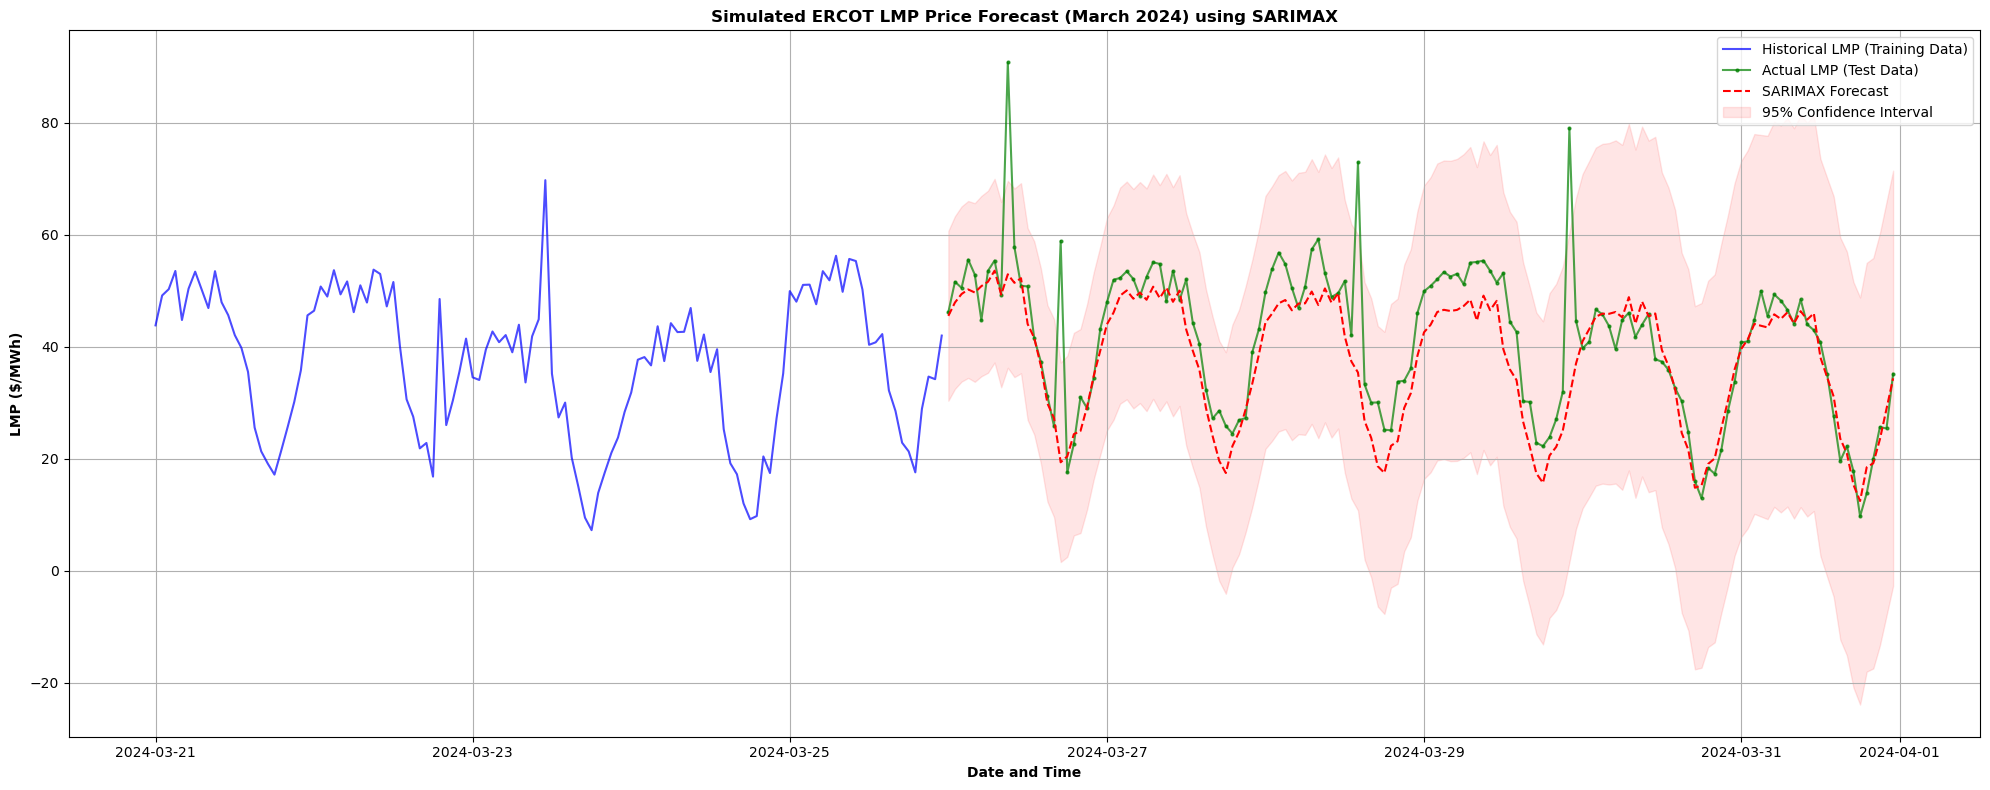


--- SARIMAX Forecasting Example Complete ---


In [21]:
# Fit SARIMAX model
# Using exogenous variables from the training set
print("Fitting SARIMAX model (this may take a moment)...")
import time
start_time = time.time()
sarimax_model = sm.tsa.statespace.SARIMAX(train_data[target],
                                          exog=train_data[exog_features],
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, S),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

sarimax_results = sarimax_model.fit(disp=False) # disp=False to suppress verbose optimization output
end_time = time.time()
fit_duration = end_time - start_time
print(f"Model fitted in {fit_duration:.2f} seconds.")
print(sarimax_results.summary())

# --- 5. Forecasting ---
print(f"\n--- 5. Forecasting for {len(test_data)} hours ---")

# For forecasting with exogenous variables, you MUST provide future values of these variables.
# In a real-world scenario, these would be *forecasts* of Load, Temp, Wind, Solar, NatGasPrice,
# and known future values for HourOfDay, DayOfWeek, DayOfMonth.
future_exog = test_data[exog_features]

# Generate forecasts
sarimax_forecast = sarimax_results.get_forecast(steps=len(test_data), exog=future_exog)
forecast_mean = sarimax_forecast.predicted_mean
conf_int = sarimax_forecast.conf_int(alpha=0.05) # 95% confidence interval

# Create a DataFrame for forecasts
forecast_df = pd.DataFrame({'Predicted_LMP': forecast_mean,
                            'LMP_Lower': conf_int[f'lower {target}'],
                            'LMP_Upper': conf_int[f'upper {target}']},
                           index=test_data.index)

print("\nForecast (first 5 values):")
print(forecast_df.head())

# --- 6. Evaluation ---
print("\n--- 6. Evaluation ---")

y_true = test_data[target]
y_pred = forecast_df['Predicted_LMP']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} $/MWh")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} $/MWh")
print(f"R-squared (R2): {r2:.3f}")


# --- 7. Visualization ---
print("\n--- 7. Visualizing Forecast ---")

plt.figure(figsize=(20, 8))
# Plot training data (a recent segment)
plt.plot(train_data.index[-24*5:], train_data[target].iloc[-24*5:], label='Historical LMP (Training Data)', color='blue', alpha=0.7)
# Plot actual test data
plt.plot(test_data.index, y_true, label='Actual LMP (Test Data)', color='green', marker='.', markersize=4, alpha=0.7)
# Plot forecasted data
plt.plot(forecast_df.index, forecast_df['Predicted_LMP'], label='SARIMAX Forecast', color='red', linestyle='--')
# Plot confidence intervals
plt.fill_between(forecast_df.index, forecast_df['LMP_Lower'], forecast_df['LMP_Upper'], color='red', alpha=0.1, label='95% Confidence Interval')

plt.title('Simulated ERCOT LMP Price Forecast (March 2024) using SARIMAX',fontweight='bold')
plt.xlabel('Date and Time',fontweight='bold')
plt.ylabel('LMP ($/MWh)',fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Forecasting.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n--- SARIMAX Forecasting Example Complete ---")


--- 7. Visualizing Forecast ---


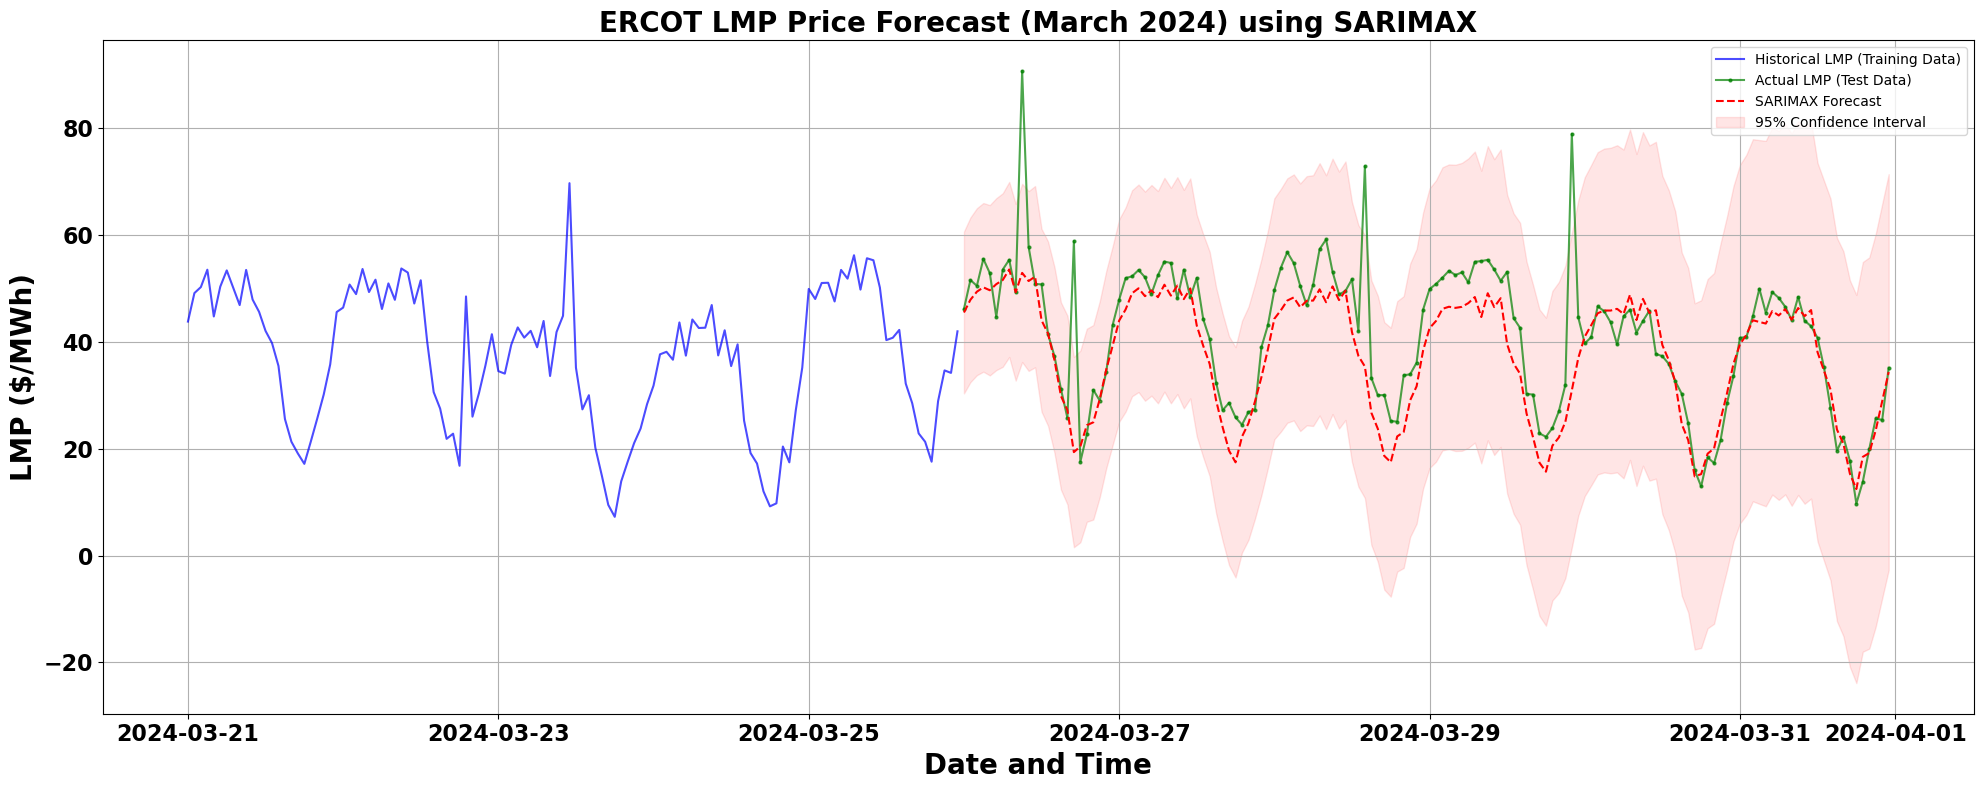


--- SARIMAX Forecasting Example Complete ---


In [22]:
# --- 7. Visualization ---
print("\n--- 7. Visualizing Forecast ---")

plt.figure(figsize=(20, 8))
# Plot training data (a recent segment)
plt.plot(train_data.index[-24*5:], train_data[target].iloc[-24*5:], label='Historical LMP (Training Data)', color='blue', alpha=0.7)
# Plot actual test data
plt.plot(test_data.index, y_true, label='Actual LMP (Test Data)', color='green', marker='.', markersize=4, alpha=0.7)
# Plot forecasted data
plt.plot(forecast_df.index, forecast_df['Predicted_LMP'], label='SARIMAX Forecast', color='red', linestyle='--')
# Plot confidence intervals
plt.fill_between(forecast_df.index, forecast_df['LMP_Lower'], forecast_df['LMP_Upper'], color='red', alpha=0.1, label='95% Confidence Interval')

plt.title('ERCOT LMP Price Forecast (March 2024) using SARIMAX',fontsize = 20, fontweight='bold')
plt.xlabel('Date and Time',fontsize = 20, fontweight='bold')
plt.ylabel('LMP ($/MWh)',fontsize = 20, fontweight='bold')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Forecasting.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n--- SARIMAX Forecasting Example Complete ---")